# The Problem

Gravitational waves are ripples in spacetime caused by the acceleration of massive objects. Predicted by Einstein in 1916 they travel at the speed of light, carrying information about their origins and the nature of gravity. The Laser Interferometer Gravitational-wave Observatory (LIGO) detects these waves using laser interferometers in Hanford, Washington, and Livingston, Louisiana. LIGO measures tiny distortions in spacetime caused by passing gravitational waves.

Having two LIGO interferometers is crucial because it allows for the verification of signals, distinguishing them from local noise and artifacts that are uncorrelated between the two locations. This dual setup also improves the localization of gravitational wave sources by comparing the arrival times of signals at each detector. Additionally, it enhances noise reduction and increases overall sensitivity, allowing for the detection of weaker signals.

To identify transient gravitational waves, scientists use matched filtering, comparing LIGO data with known templates from systems we can analytically or numerically calculate their gravitational-wave emission, like those from merging black holes. This method is effective for well-understood sources but less so for unknown phenomena where signal morphologies are poorly modeled or remain completely known.

The Anomaly Detection Challenge focuses on data from LIGO's O3 observations. These are gravitational-wave strain, h(t) time series recorded by two LIGO interferometers. We provide several datasets, including whitened, bandpass-filtered data from O3, with known GW events corresponding to binary coalesences removed. Additionally, the dataset contains simulated signals injected into the real instrument data. Participants are tasked with training their models primarily on the instrument data to detect anomalies. They can also leverage information from the simulated signals to enhance their detection methods. This challenge integrates astrophysics with machine learning, encouraging innovative approaches to anomaly detection in gravitational-wave astronomy.

#### Known transient GW sources (detectable with matched-filtering pipelines)

- Binary Black Hole (BBH) Mergers

    * Two black holes orbiting each other and eventually merging. Produce strong and detectable gravitational waves during the final moments of the merger.

- Binary Neutron Star (BNS) Mergers

    * Two neutron stars spiraling together and merging. Emit gravitational waves as they orbit and merge, followed by electromagnetic signals in the full spectrum, including gamma-ray bursts.

- Black Hole - Neutron Star (BHNS) Mergers

    * A black hole and a neutron star in a binary system merging. Create gravitational waves and potentially a variety of electromagnetic emissions.

#### Unmodeled transient GW sources appearing as "anomalies" (not yet detected with matched-filtering pipeline)

- Supernovae

    * Explosive deaths of massive stars. Can produce gravitational waves, especially in cases where the explosion is asymmetric.

- Neutron Star Glitches

    * Sudden, small change in the spin frequency of pulsars may be associated with emission of transient gravitational-waves

- Cosmic Strings

    * Hypothetical one-dimensional topological defects in spacetime predicted by some theories of the early universe. Could produce bursts of gravitational waves when they interact or oscillate.

- Fast Radio Bursts, Gamma-Ray Bursts

    * Astrophysical phenomena/systems for which we do not have a complete picture of the progenitor but energetic enough to be plausibly associated with gravitational-wave emission

- Completely unknown/unthought of sources

    * GW detectors are fairly new instruments and the GW sky is largely unexplored-- surprises with completely new astrophysical systems/source is always a possibility!

These anomalies present a significant challenge and opportunity for innovation in gravitational wave transient detection, as their unpredictable nature makes them difficult to detect with traditional matched-filtering methods.

# Required libraries

- NumPy

- Tensorflow

- Matplotlib

- Scikit-learn

In [ ]:
# Let's start with necessary imports
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data and normalize it
background = np.load('/content/drive/My Drive/Colab Notebooks/background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load('/content/drive/My Drive/Colab Notebooks/bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load('/content/drive/My Drive/Colab Notebooks/sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

KeyboardInterrupt: 

In [ ]:
# load data and normalize it
background = np.load('/content/drive/MyDrive/Colab Notebooks/background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)
print(f"Number of background cases: {len(background)}")

bbh = np.load('/content/drive/MyDrive/Colab Notebooks/bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)
print(f"Number of BBH cases: {len(bbh)}")

sglf = np.load('/content/drive/MyDrive/Colab Notebooks/sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)
print(f"Number of SGLF cases: {len(sglf)}")

Number of background cases: 100000
Number of BBH cases: 100000
Number of SGLF cases: 100000


In [ ]:
# load data and normalize it
background = np.load('background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)
print(f"Number of background cases: {len(background)}")

bbh = np.load('bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)
print(f"Number of BBH cases: {len(bbh)}")

sglf = np.load('sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)
print(f"Number of SGLF cases: {len(sglf)}")

FileNotFoundError: [Errno 2] No such file or directory: 'background.npz'

In [ ]:
# Create train and test datasets

data = np.concatenate((background, bbh, sglf), axis=0)
labels = np.concatenate((np.zeros(len(background)), np.zeros(len(bbh)), np.ones(len(sglf))), axis=0)[:, np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(
     data, labels, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (240000, 200, 2) (60000, 200, 2)
y train/test shapes: (240000, 1) (60000, 1)


In [ ]:
background_cov_indices = np.random.choice(background.shape[0], 10000, replace=False)
bbh_cov_indices = np.random.choice(bbh.shape[0], 10000, replace=False)
sglf_cov_indices = np.random.choice(sglf.shape[0], 10000, replace=False)

background_cov = background[background_cov_indices]
bbh_cov = bbh[bbh_cov_indices]
sglf_cov = sglf[sglf_cov_indices]

In [ ]:
# Create train and test datasets

data = np.concatenate((background_cov, bbh_cov, sglf_cov), axis=0)
labels = np.concatenate((np.zeros(len(background_cov)), np.zeros(len(bbh_cov)), np.ones(len(sglf_cov))), axis=0)[:, np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(
     data, labels, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (24000, 200, 2) (6000, 200, 2)
y train/test shapes: (24000, 1) (6000, 1)


## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

The model includes the following components:

`Transformer Encoder`: Includes residual connections, layer normalization, dropout, and multi-head attention layers. The projection layers are implemented using `keras.layers.Conv1D`. These layers can be stacked multiple times.

`Dense Decoder`: After the transformer encoder, the dense decoder is used. It flattens the input, applies several dense layers with residual connections, dropout, and layer normalization, and then reshapes the output back to the original input shape.

The final layer of the model is a dense layer that outputs a tensor of the same shape as the input.


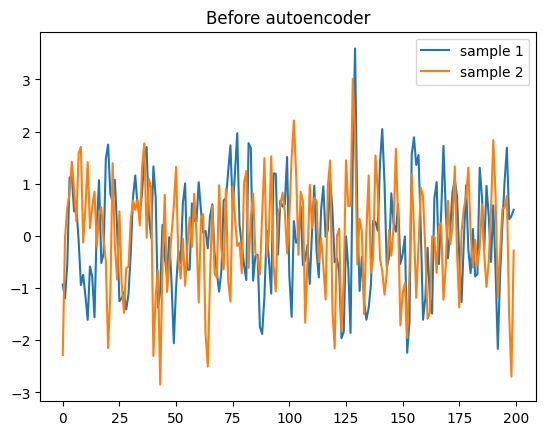

In [ ]:
plt.figure()
plt.plot(x_test[0, :, 0])
plt.plot(x_test[0, :, 1])
plt.title("Before autoencoder")
plt.legend(["sample 1", "sample 2"], loc="best")
plt.show()
plt.close()

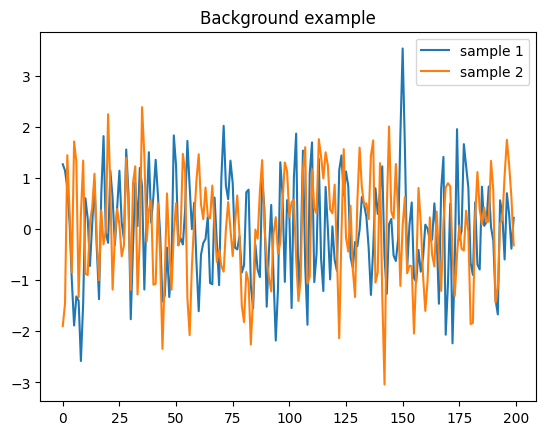

In [ ]:
plt.figure()
plt.plot(background[0, :, 0])
plt.plot(background[0, :, 1])
plt.title("Background example")
plt.legend(["sample 1", "sample 2"], loc="best")
plt.show()
plt.close()

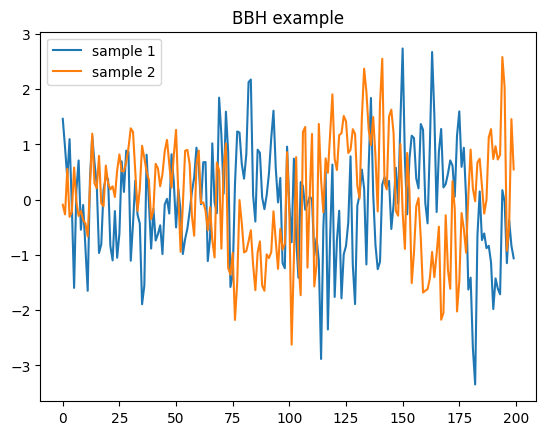

In [ ]:
plt.figure()
plt.plot(bbh[0, :, 0])
plt.plot(bbh[0, :, 1])
plt.title("BBH example")
plt.legend(["sample 1", "sample 2"], loc="best")
plt.show()
plt.close()

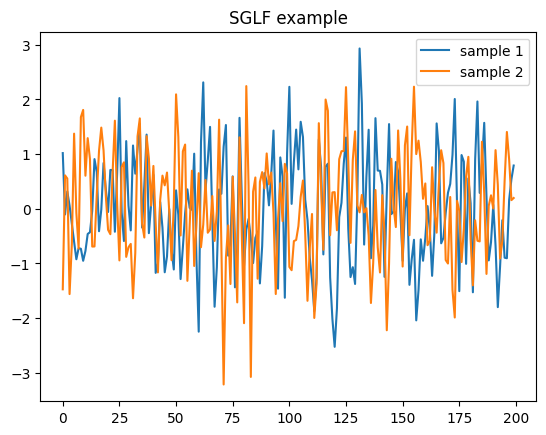

In [ ]:
plt.figure()
plt.plot(sglf[0, :, 0])
plt.plot(sglf[0, :, 1])
plt.title("SGLF example")
plt.legend(["sample 1", "sample 2"], loc="best")
plt.show()
plt.close()

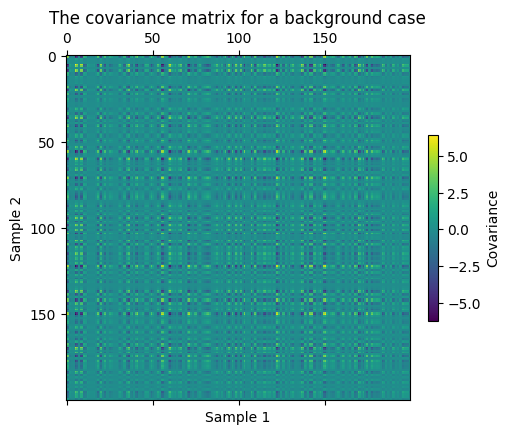

In [ ]:
background_cov = np.cov(background[0])

ax = plt.matshow(background_cov)
plt.xlabel("Sample 1")
plt.ylabel("Sample 2")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("Covariance")
plt.title("The covariance matrix for a background case")
plt.show()
plt.close()

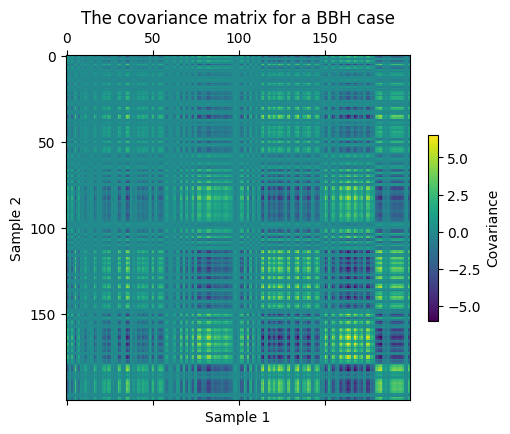

In [ ]:
bbh_cov = np.cov(bbh[0])

ax = plt.matshow(bbh_cov)
plt.xlabel("Sample 1")
plt.ylabel("Sample 2")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("Covariance")
plt.title("The covariance matrix for a BBH case")
plt.show()
plt.close()

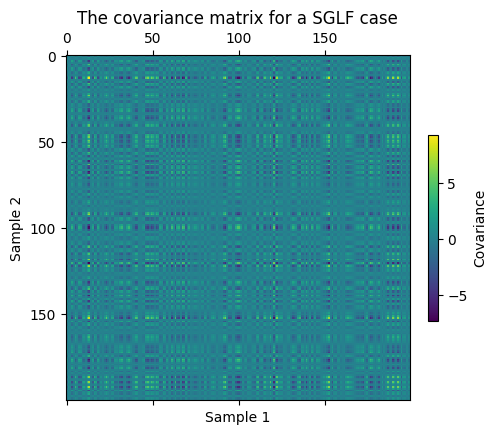

In [ ]:
sglf_cov = np.cov(sglf[1])

ax = plt.matshow(sglf_cov)
plt.xlabel("Sample 1")
plt.ylabel("Sample 2")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("Covariance")
plt.title("The covariance matrix for a SGLF case")
plt.show()
plt.close()

In [ ]:
L = 100 # The window length.
K = background.shape[1] - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.stack([background[0][i:i+L] for i in range(0,K)], axis=1)
print(background[0].shape)
print(X.shape)

(200, 2)
(100, 101, 2)


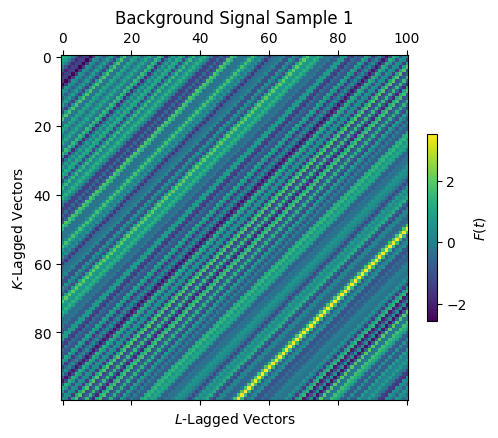

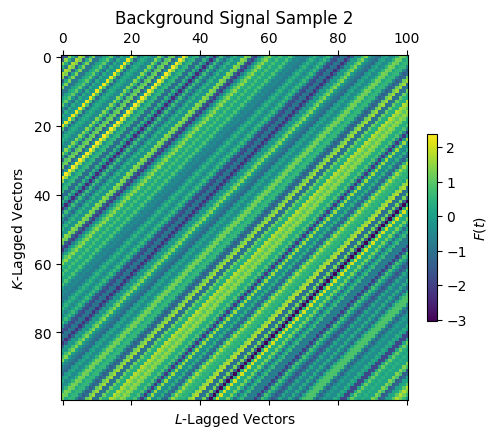

In [ ]:
ax = plt.matshow(X[0])
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("Background Signal Sample 1");
plt.show()
plt.close()

ax = plt.matshow(X[1])
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("Background Signal Sample 2");
plt.show()
plt.close()

In [ ]:
d = np.linalg.matrix_rank(X[:, :, 0]) # The intrinsic dimensionality of the trajectory space.
print(d)

X = np.moveaxis(X, -1, 0)
print(X.shape)
# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X[0])
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless,
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i).
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

2
(101, 2, 100)


In [ ]:
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

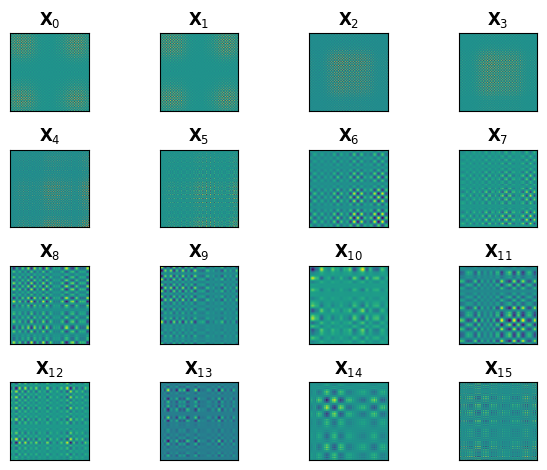

In [ ]:
n = min(16, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
d = np.linalg.matrix_rank(X[:, :, 1]) # The intrinsic dimensionality of the trajectory space.
print(d)

X = np.moveaxis(X, -1, 0)
print(X.shape)
# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X[1])
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless,
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i).
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

100
(2, 100, 101)


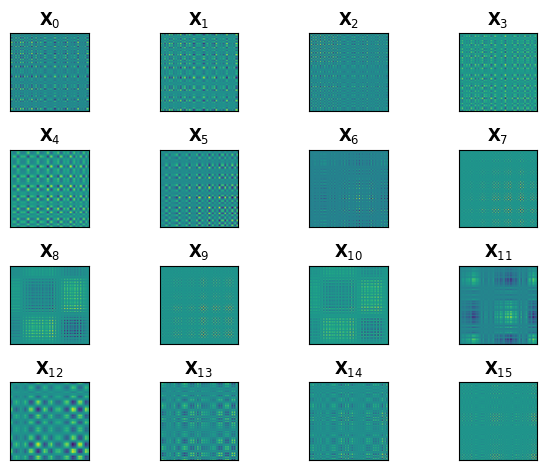

In [ ]:
n = min(16, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
L = 100 # The window length.
K = bbh.shape[1] - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.stack([bbh[0][i:i+L] for i in range(0,K)], axis=1)
print(bbh[0].shape)
print(X.shape)

(200, 2)
(100, 101, 2)


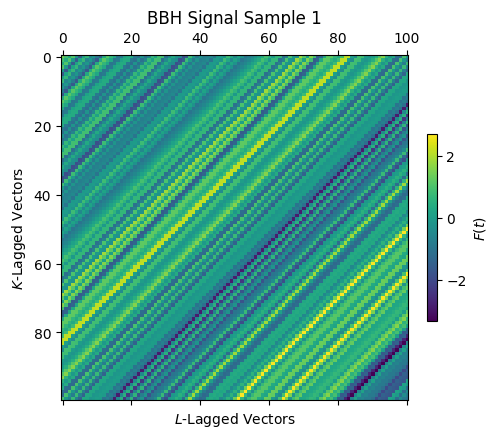

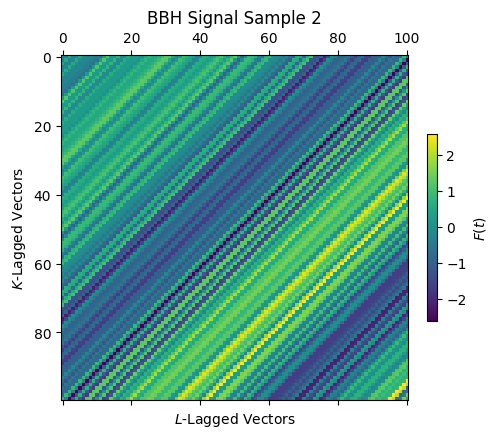

In [ ]:
ax = plt.matshow(X[:, :, 0])
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("BBH Signal Sample 1");
plt.show()
plt.close()

ax = plt.matshow(X[:, :, 1])
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("BBH Signal Sample 2");
plt.show()
plt.close()

In [ ]:
d = np.linalg.matrix_rank(X[:, :, 0]) # The intrinsic dimensionality of the trajectory space.
print(d)

X = np.moveaxis(X, -1, 0)
print(X.shape)
# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X[0])
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless,
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i).
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

100
(2, 100, 101)


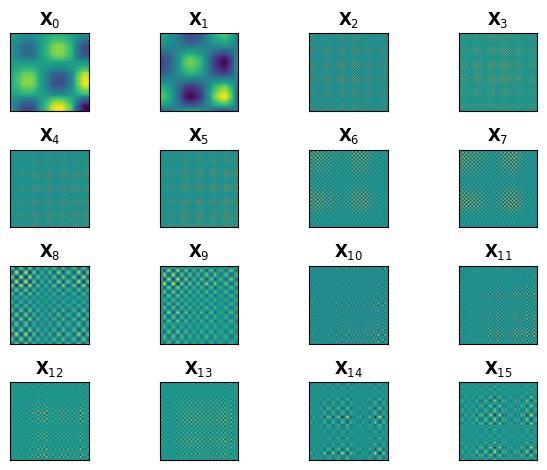

In [ ]:
n = min(16, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
d = np.linalg.matrix_rank(X[:, :, 1]) # The intrinsic dimensionality of the trajectory space.
print(d)

X = np.moveaxis(X, -1, 0)
print(X.shape)

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X[1])
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless,
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i).
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

100
(2, 100, 101)


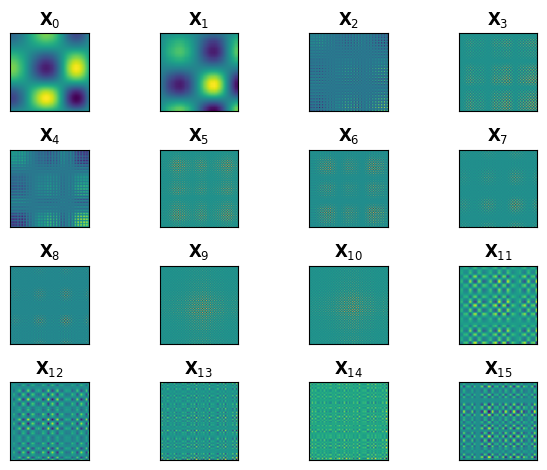

In [ ]:
n = min(16, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
L = 100 # The window length.
K = sglf.shape[1] - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.stack([sglf[0][i:i+L] for i in range(0,K)], axis=1)
print(sglf[0].shape)
print(X.shape)

(200, 2)
(100, 101, 2)


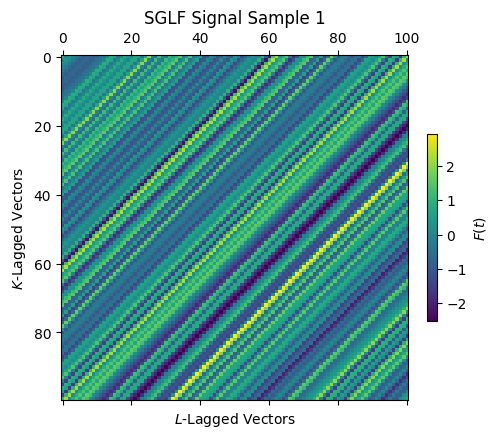

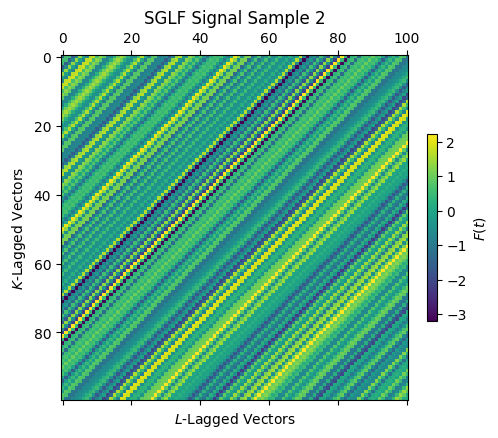

In [ ]:
ax = plt.matshow(X[:, :, 0])
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("SGLF Signal Sample 1");
plt.show()
plt.close()

ax = plt.matshow(X[:, :, 1])
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("SGLF Signal Sample 2");
plt.show()
plt.close()

In [ ]:
d = np.linalg.matrix_rank(X[:, :, 0]) # The intrinsic dimensionality of the trajectory space.
print(d)

X = np.moveaxis(X, -1, 0)
print(X.shape)
# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X[0])
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless,
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i).
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

100
(2, 100, 101)


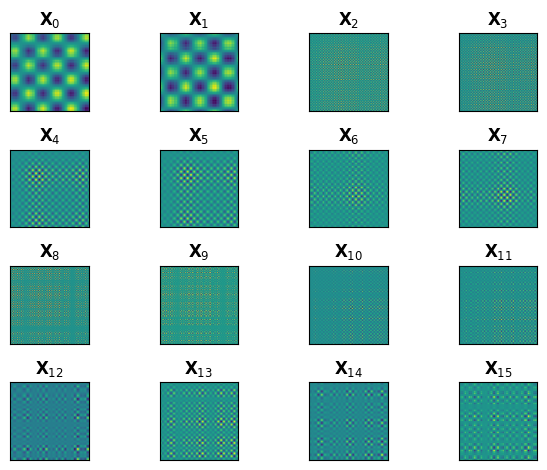

In [ ]:
n = min(16, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
d = np.linalg.matrix_rank(X[:, :, 1]) # The intrinsic dimensionality of the trajectory space.
print(d)

X = np.moveaxis(X, -1, 0)
print(X.shape)
# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X[1])
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless,
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i).
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

100
(2, 100, 101)


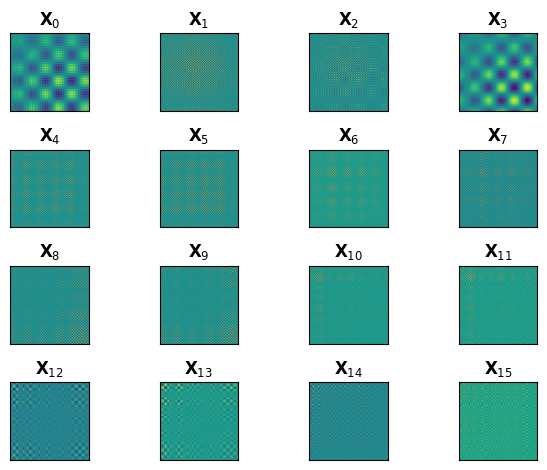

In [ ]:
n = min(16, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
class Autoencoder:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'autoencoder.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1

# build the model
autoencoder = Autoencoder()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/50
 456/6000 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 3.0650

KeyboardInterrupt: 

In [ ]:
# Save the entire model as a SavedModel.
__file__=''
!mkdir -p saved_model
autoencoder.save('')

In [ ]:
plt.figure()
plt.plot(x_test[0, :, 0])
plt.plot(autoencoder.predict(x_test[0, :, 0]))
plt.title("Autoencoder in action 1")
plt.legend(["original", "reconstructed"], loc="best")
plt.show()
plt.close()

plt.figure()
plt.plot(x_test[0, :, 1])
plt.plot(autoencoder.predict(x_test[0, :, 1]))
plt.title("Autoencoder in action 2")
plt.legend(["original", "reconstructed"], loc="best")
plt.show()
plt.close()

NameError: name 'plt' is not defined

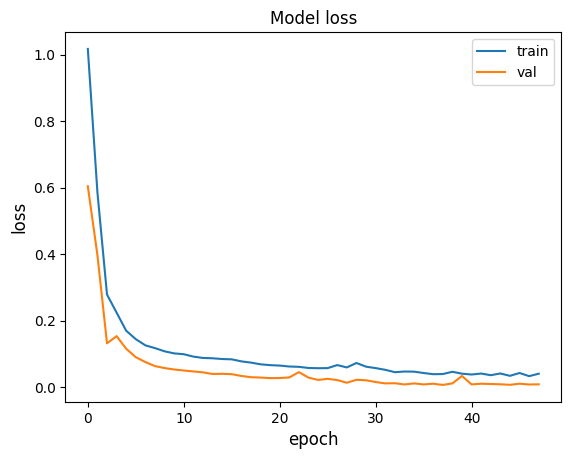

In [ ]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


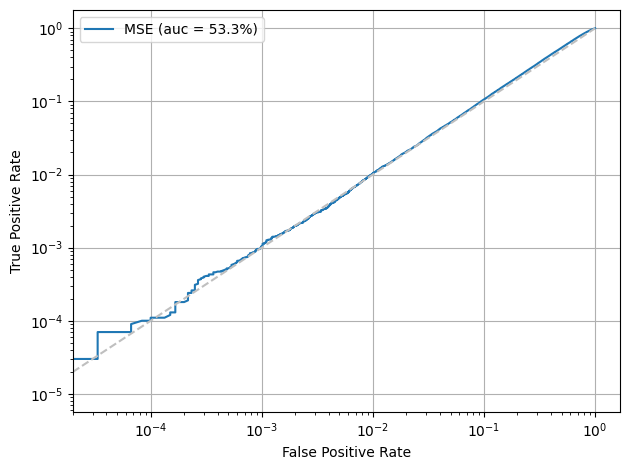

In [ ]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh)

make_plot_roc_curves(background_test, signal_test)

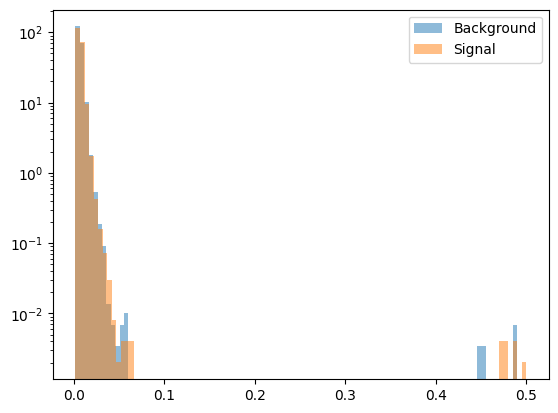

In [ ]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [ ]:
cov_matrix_list = []
for i in range(background.shape[0]):
    cov_matrix_list.append(np.cov(background[i]))

cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

In [ ]:
class Covariance_Model:
    def __init__(self):
        super().__init__()

    def conv_encoder(self, inputs, ff_dim, kernel_size, strides=1, dropout=0):
        x = layers.Conv2D(filters=16, kernel_size=kernel_size, strides=strides, activation="relu")(inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.MaxPool2D((3, 3))(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters=8, kernel_size=kernel_size, strides=strides, activation="relu")(inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.MaxPool2D((3, 3))(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters=1, kernel_size=x.shape[1], activation='sigmoid')(x)
        x = layers.Flatten()(x)

        return x

    def dense_predictor(self, inputs, pred_dim, dropout=0):
        # Flattens the input to apply dense layers
        x = layers.Flatten()(inputs)

        current_units = int(np.power(2, np.ceil(np.log2(x.shape[-1]))))

        while(current_units > pred_dim):
          current_units //= 2
          x = layers.Dense(current_units, activation="relu")(x)
          x = layers.Dropout(dropout)(x)
          x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Calculates probabilities for prediction
        x = layers.Dense(1, activation="sigmoid")(x)
        return x

    def build_model(self, input_shape, kernel_size, ff_dim, pred_dim, strides=1, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs

        outputs = self.conv_encoder(x, ff_dim=ff_dim, kernel_size=kernel_size, strides=strides)

        print(f"Incoming shape: {x.shape}")

        # Predictor
        # outputs = self.dense_predictor(x, pred_dim, dropout)

        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                   keras.metrics.TruePositives(name='tp'),
                   keras.metrics.FalsePositives(name='fp'),
                   keras.metrics.TrueNegatives(name='tn'),
                   keras.metrics.FalseNegatives(name='fn')]

        self.model = keras.Model(inputs, outputs)
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                           metrics=metrics)

    def predict(self, X, batch_size=32):
        return np.where(self.model.predict(X, batch_size=batch_size) >= 0.5, 1, 0)

    def __call__(self, inputs, batch_size=64):
        return self.model.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.model.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.model = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, y_train, epochs=1, validation_split=0.0, **kwargs):
      if validation_split > 0:
        x_train, x_val, y_train, y_val = train_test_split(
            data, labels, test_size=validation_split, random_state=42)

      if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
      else:
        batch_size = 1

      for i in range(epochs):
        print(f"Epoch {i + 1}/{epochs}:")
        num_batches = int(np.ceil(x_train.shape[0]/batch_size))
        training_metrics = np.zeros(6)
        batch_index = 0
        training_loss = 0.0
        training_accuracy = 0.0
        training_tp = 0.0
        training_tn = 0.0
        training_fp = 0.0
        training_fn = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        val_tp = 0.0
        val_tn = 0.0
        val_fp = 0.0
        val_fn = 0.0

        for batch_number in range(num_batches):
          batch_x, batch_y = x_train[batch_index:min(batch_index + batch_size, x_train.shape[0])], y_train[batch_index:min(batch_index + batch_size, y_train.shape[0])]
          cov_matrix_list = []
          for i in range(batch_x.shape[0]):
            cov_matrix_list.append(np.cov(batch_x[i]))

          cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

          # print(f"Processing batch {batch_number + 1}/{num_batches}")
          training_metrics = self.model.train_on_batch(cov_matrix, batch_y, class_weight={0:0.67, 1:1.33}, return_dict=True)
          training_loss += training_metrics['loss']/num_batches
          training_accuracy += training_metrics['accuracy']/num_batches
          training_tp += training_metrics['tp']
          training_tn += training_metrics['tn']
          training_fp += training_metrics['fp']
          training_fn += training_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Training metrics: loss = {training_loss}, accuracy = {training_accuracy}, TP = {training_tp}, TN = {training_tn}, FP = {training_fp}, FN = {training_fn}")

        num_batches = int(np.ceil(x_val.shape[0]/batch_size))
        val_metrics = np.zeros(6)
        batch_index = 0
        for batch_number in range(num_batches):
          batch_x, batch_y = x_val[batch_index:min(batch_index + batch_size, x_val.shape[0])], y_val[batch_index:min(batch_index + batch_size, y_val.shape[0])]
          cov_matrix_list = []
          for i in range(batch_x.shape[0]):
            cov_matrix_list.append(np.cov(batch_x[i]))

          cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

          val_metrics = self.model.test_on_batch(cov_matrix, batch_y, return_dict=True)
          val_loss += val_metrics['loss']/num_batches
          val_accuracy += val_metrics['accuracy']/num_batches
          val_tp += val_metrics['tp']
          val_tn += val_metrics['tn']
          val_fp += val_metrics['fp']
          val_fn += val_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Validation metrics: loss = {val_loss}, accuracy = {val_accuracy}, TP = {val_tp}, TN = {val_tn}, FP = {val_fp}, FN = {val_fn}")

      return training_metrics, val_metrics

# Example usage:
input_shape = (x_train.shape[1], x_train.shape[1], 1)
kernel_size = 20
strides = 5
ff_dim = 64
pred_dim = 64
dropout = 0.1
fine_tuning_split = 0.0

# build the model
predictor = Covariance_Model()
predictor.build_model(
    input_shape=input_shape,
    kernel_size=kernel_size,
    strides=strides,
    ff_dim=ff_dim,
    pred_dim=pred_dim,
    dropout=dropout
)

# Assuming x_train is your input data
training_loss, val_loss = predictor.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Incoming shape: (None, 200, 200, 1)
Epoch 1/20:
Training metrics: loss = 0.2527904891173045, accuracy = 0.8774166666666626, TP = 34232.0, TN = 71058.0, FP = 8929.0, FN = 5781.0
Validation metrics: loss = 0.1605173025383498, accuracy = 0.9384550462399445, TP = 9326.0, TN = 18828.0, FP = 1185.0, FN = 661.0
Epoch 2/20:
Training metrics: loss = 0.11067365287840385, accuracy = 0.9579916666666755, TP = 37508.0, TN = 77451.0, FP = 2536.0, FN = 2505.0
Validation metrics: loss = 0.11231467220733665, accuracy = 0.9596992714572802, TP = 9474.0, TN = 19317.0, FP = 696.0, FN = 513.0
Epoch 3/20:
Training metrics: loss = 0.08566587781161081, accuracy = 0.9686083333333476, TP = 38141.0, TN = 78092.0, FP = 1895.0, FN = 1872.0
Validation metrics: loss = 0.09607136278931515, accuracy = 0.9656960731630374, TP = 9514.0, TN = 19457.0, FP = 556.0, FN = 473.0
Epoch 4/20:
Training metrics: loss = 0.07433319678703944, accuracy = 0.9726083333333496, TP = 38406.0, TN = 78307.0, FP = 1680.0, FN = 1607.0
Validation

KeyboardInterrupt: 

In [ ]:
__file__='saved_model'
!mkdir -p saved_model
predictor.save('')

In [ ]:
class SSA_Model:
    def __init__(self):
        super().__init__()

    def conv_encoder(self, inputs, ff_dim, kernel_size, strides=1, dropout=0):
        x = layers.Conv2D(filters=16, kernel_size=kernel_size, strides=strides, activation="relu")(inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.MaxPool2D((3, 3))(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters=8, kernel_size=kernel_size, strides=strides, activation="relu")(inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.MaxPool2D((3, 3))(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters=1, kernel_size=(x.shape[1], x.shape[2]), activation='sigmoid')(x)
        x = layers.Flatten()(x)

        return x

    def dense_predictor(self, inputs, pred_dim, dropout=0):
        # Flattens the input to apply dense layers
        x = layers.Flatten()(inputs)

        current_units = int(np.power(2, np.ceil(np.log2(x.shape[-1]))))

        while(current_units > pred_dim):
          current_units //= 2
          x = layers.Dense(current_units, activation="relu")(x)
          x = layers.Dropout(dropout)(x)
          x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Calculates probabilities for prediction
        x = layers.Dense(1, activation="sigmoid")(x)
        return x

    def build_model(self, input_shape, kernel_size, ff_dim, pred_dim, strides=1, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs

        outputs = self.conv_encoder(x, ff_dim=ff_dim, kernel_size=kernel_size, strides=strides)

        # Predictor
        # outputs = self.dense_predictor(x, pred_dim, dropout)

        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                   keras.metrics.TruePositives(name='tp'),
                   keras.metrics.FalsePositives(name='fp'),
                   keras.metrics.TrueNegatives(name='tn'),
                   keras.metrics.FalseNegatives(name='fn')]

        self.model = keras.Model(inputs, outputs)
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                           metrics=metrics)

    def predict(self, X, batch_size=32):
        return np.where(self.model.predict(X, batch_size=batch_size) >= 0.5, 1, 0)

    def __call__(self, inputs, batch_size=64):
        return self.model.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.model.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.model = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, y_train, epochs=1, validation_split=0.0, **kwargs):
      L = 100 # The window length.
      K = x_train.shape[1] - L + 1

      if validation_split > 0:
        x_train, x_val, y_train, y_val = train_test_split(
            data, labels, test_size=validation_split, random_state=42)

      if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
      else:
        batch_size = 1

      if 'num_components' in kwargs:
        num_components = kwargs['num_components']
      else:
        num_components = 8

      for i in range(epochs):
        print(f"Epoch {i + 1}/{epochs}:")
        num_batches = int(np.ceil(x_train.shape[0]/batch_size))
        training_metrics = np.zeros(6)
        batch_index = 0
        training_loss = 0.0
        training_accuracy = 0.0
        training_tp = 0.0
        training_tn = 0.0
        training_fp = 0.0
        training_fn = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        val_tp = 0.0
        val_tn = 0.0
        val_fp = 0.0
        val_fn = 0.0

        for batch_number in range(num_batches):
          batch_x, batch_y = x_train[batch_index:min(batch_index + batch_size, x_train.shape[0])], y_train[batch_index:min(batch_index + batch_size, y_train.shape[0])]

          X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

          X = np.moveaxis(X, -1, -3)

          U, Sigma, V = np.linalg.svd(X)
          V = V.T

          svd_matrix_list = []

          for j in range(batch_x.shape[0]):
            batch_svd = []
            for z in range(0,num_components):
              batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])
            svd_matrix_list.append(np.array(batch_svd))

          svd_matrix = np.stack(svd_matrix_list)


          svd_matrix = np.moveaxis(svd_matrix, -3, -1)

          # print(f"Processing batch {batch_number + 1}/{num_batches}")
          training_metrics = self.model.train_on_batch(svd_matrix, batch_y, class_weight={0:0.67, 1:1.33}, return_dict=True)
          training_loss += training_metrics['loss']/num_batches
          training_accuracy += training_metrics['accuracy']/num_batches
          training_tp += training_metrics['tp']
          training_tn += training_metrics['tn']
          training_fp += training_metrics['fp']
          training_fn += training_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Training metrics: loss = {training_loss}, accuracy = {training_accuracy}, TP = {training_tp}, TN = {training_tn}, FP = {training_fp}, FN = {training_fn}")

        num_batches = int(np.ceil(x_val.shape[0]/batch_size))
        val_metrics = np.zeros(6)
        batch_index = 0
        for batch_number in range(num_batches):
          batch_x, batch_y = x_val[batch_index:min(batch_index + batch_size, x_val.shape[0])], y_val[batch_index:min(batch_index + batch_size, y_val.shape[0])]

          X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

          X = np.moveaxis(X, -1, -3)

          U, Sigma, V = np.linalg.svd(X)
          V = V.T

          svd_matrix_list = []

          for j in range(batch_x.shape[0]):
            batch_svd = []
            for z in range(0,num_components):
              batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])
            svd_matrix_list.append(np.array(batch_svd))

          svd_matrix = np.stack(svd_matrix_list)

          svd_matrix = np.moveaxis(svd_matrix, -3, -1)

          val_metrics = self.model.test_on_batch(svd_matrix, batch_y, return_dict=True)
          val_loss += val_metrics['loss']/num_batches
          val_accuracy += val_metrics['accuracy']/num_batches
          val_tp += val_metrics['tp']
          val_tn += val_metrics['tn']
          val_fp += val_metrics['fp']
          val_fn += val_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Validation metrics: loss = {val_loss}, accuracy = {val_accuracy}, TP = {val_tp}, TN = {val_tn}, FP = {val_fp}, FN = {val_fn}")

      return training_metrics, val_metrics

# Example usage:
input_shape = (101, 100, 16)
kernel_size = 10
strides = 2
ff_dim = 64
pred_dim = 64
dropout = 0.1
fine_tuning_split = 0.0

# build the model
predictor = SSA_Model()
predictor.build_model(
    input_shape=input_shape,
    kernel_size=kernel_size,
    strides=strides,
    ff_dim=ff_dim,
    pred_dim=pred_dim,
    dropout=dropout
)

# Assuming x_train is your input data
training_loss, val_loss = predictor.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/20:
Training metrics: loss = 0.2670959119722248, accuracy = 0.875104166666666, TP = 13491.0, TN = 28514.0, FP = 3509.0, FN = 2486.0
Validation metrics: loss = 0.20641123681267104, accuracy = 0.9153333333333308, TP = 3632.0, TN = 7352.0, FP = 625.0, FN = 391.0
Epoch 2/20:
Training metrics: loss = 0.1525178507709256, accuracy = 0.9376666666666672, TP = 14503.0, TN = 30505.0, FP = 1518.0, FN = 1474.0
Validation metrics: loss = 0.16667548692226405, accuracy = 0.9351666666666644, TP = 3728.0, TN = 7494.0, FP = 483.0, FN = 295.0
Epoch 3/20:
Training metrics: loss = 0.12152374543249612, accuracy = 0.9512083333333368, TP = 14781.0, TN = 30877.0, FP = 1146.0, FN = 1196.0
Validation metrics: loss = 0.14706255718568947, accuracy = 0.9430833333333319, TP = 3776.0, TN = 7541.0, FP = 436.0, FN = 247.0
Epoch 4/20:
Training metrics: loss = 0.10293059866068267, accuracy = 0.9585000000000062, TP = 14967.0, TN = 31041.0, FP = 982.0, FN = 1010.0
Validation metrics: loss = 0.13287504547834408, accu

KeyboardInterrupt: 

In [ ]:
__file__='saved_model'
!mkdir -p saved_model
predictor.save('')

In [ ]:
__file__='/content/drive/MyDrive/Colab Notebooks/'
pretrained_model = Autoencoder()
pretrained_model.load()

# Check its architecture
pretrained_model.ae.summary()

pretrained_model.ae.save_weights('autoencoder_weights.weights.h5')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 2)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 200, 2)         │          1,410 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 200, 2)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 200, 2)         │              4 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 200, 2)         │              0 │ layer_normalization[0… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 200, 64)        │            192 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 200, 64)        │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 200, 2)         │            130 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 200, 2)         │              4 │ conv1d_1[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 200, 2)         │          1,410 │ add_1[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 200, 2)         │              4 │ dropout_4[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 200, 2)         │              0 │ layer_normalization_2… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 200, 64)        │            192 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)  

 Total params: 206,060 (804.93 KB)

 Trainable params: 68,686 (268.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,374 (536.62 KB)

In [ ]:
class Model:
    def __init__(self):
        super().__init__()
        self.encoder_layers = 0
        self.predictor_layers = 0

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout, trainable=False,
        )(inputs, inputs)
        x = layers.Dropout(dropout, trainable=False)(x)
        x = layers.LayerNormalization(epsilon=1e-6, trainable=False)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", trainable=False)(res)
        x = layers.Dropout(dropout, trainable=False)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, trainable=False)(x)
        x = layers.LayerNormalization(epsilon=1e-6, trainable=False)(x)

        self.encoder_layers += 9
        return x + res

    def dense_predictor(self, inputs, pred_dim, dropout=0):
        # Flattens the input to apply dense layers
        x = layers.Flatten()(inputs)
        self.predictor_layers += 1

        current_units = int(np.power(2, np.ceil(np.log2(x.shape[-1]))))

        while(current_units > pred_dim):
          current_units //= 2
          x = layers.Dense(current_units, activation="leaky_relu")(x)
          x = layers.Dropout(dropout)(x)
          x = layers.LayerNormalization(epsilon=1e-6)(x)
          self.predictor_layers += 3

        # Calculates probabilities for prediction
        x = layers.Dense(1, activation="sigmoid")(x)
        self.predictor_layers += 1
        return x

    def build_model(self, input_shape, head_size, num_heads, ff_dim, pred_dim, num_transformer_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        # Predictor
        outputs = self.dense_predictor(x, pred_dim, dropout)

        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                   keras.metrics.TruePositives(name='tp'),
                   keras.metrics.FalsePositives(name='fp'),
                   keras.metrics.TrueNegatives(name='tn'),
                   keras.metrics.FalseNegatives(name='fn'),
                   keras.metrics.F1Score(name='f1_score')]

        self.model = keras.Model(inputs, outputs)
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                           metrics=metrics)

    def predict(self, X, batch_size=32):
        return np.where(self.model.predict(X, batch_size=batch_size) >= 0.5, 1, 0)

    def __call__(self, inputs, batch_size=64):
        return self.model.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.model.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.model = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, y_train, epochs=1, tuning_split=0.0, validation_split=0.0, **kwargs):
      if validation_split > 0:
        x_train, x_val, y_train, y_val = train_test_split(
            data, labels, test_size=validation_split, random_state=42)

      if tuning_split > 0:
        history_1 = self.model.fit(x_train, y_train, epochs=int(epochs*(1-tuning_split)),
                                 validation_data=(x_val, y_val), **kwargs)
        for layer in self.model.layers: layer.trainable = True

        history_2 = self.model.fit(x_train, y_train, epochs=int(epochs*tuning_split),
                                      validation_data=(x_val, y_val), **kwargs)
        history = {}
        history['loss'] = np.concatenate(history_1.history['loss'], history_2.history['loss'])
        history['val_loss'] = np.concatenate(history_1.history['val_loss'], history_2.history['val_loss'])
      else:
        history = self.model.fit(x_train, y_train, epochs=epochs,
                                 validation_data=(x_val, y_val), **kwargs)
      return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
pred_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1
fine_tuning_split = 0.2

# build the model
predictor = Model()
predictor.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    pred_dim=pred_dim,
    num_transformer_blocks=num_transformer_blocks,
    dropout=dropout
)

predictor.model.load_weights('autoencoder_weights.weights.h5', skip_mismatch=True)

# Assuming x_train is your input data
history = predictor.fit(
    x_train,
    y_train,
    epochs=5,
    tuning_split=fine_tuning_split,
    validation_split=0.2,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:629: UserWarning: A total of 7 objects could not be loaded. Example error message for object <Dense name=dense_6, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(400, 256), Received: value.shape=(400, 64). Target variable: <Variable path=dense_6/kernel, shape=(400, 256), dtype=float32, value=[[-0.00643272  0.01929118 -0.00534128 ...  0.04798409  0.0935115
   0.04703196]
 [-0.02188373 -0.00243694  0.06306403 ... -0.03265082 -0.02013429
  -0.06983075]
 [-0.04878021 -0.00781693  0.05577386 ...  0.05225589 -0.07130202
  -0.08663586]
 ...
 [ 0.0887601  -0.05606027  

Epoch 1/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 91s 10ms/step - accuracy: 0.7230 - f1_score: 0.5008 - fn: 19446.0957 - fp: 10519.0547 - loss: 0.5307 - tn: 69456.9375 - tp: 20609.9062 - val_accuracy: 0.8710 - val_f1_score: 0.5011 - val_fn: 5173.0000 - val_fp: 2565.0000 - val_loss: 0.3012 - val_tn: 37377.0000 - val_tp: 14885.0000
Epoch 2/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 131s 10ms/step - accuracy: 0.8668 - f1_score: 0.4987 - fn: 9403.7266 - fp: 6271.7949 - loss: 0.3034 - tn: 73869.0469 - tp: 30487.4238 - val_accuracy: 0.9068 - val_f1_score: 0.5011 - val_fn: 3319.0000 - val_fp: 2276.0000 - val_loss: 0.2271 - val_tn: 37666.0000 - val_tp: 16739.0000
Epoch 3/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - accuracy: 0.9016 - f1_score: 0.4998 - fn: 7103.6992 - fp: 4565.6475 - loss: 0.2366 - tn: 75464.7344 - tp: 32897.9102 - val_accuracy: 0.9211 - val_f1_score: 0.5011 - val_fn: 3193.0000 - val_fp: 1542.0000 - val_loss: 0.1997 - val_tn: 38400.0000 - val_tp: 16865.0000
Epoch 4/4
7500/7500 ━━━━━━━━━━━━━━

TypeError: 'list' object cannot be interpreted as an integer

True positive rate: 90.735164973027223685861247020449%

True negative rate: 97.205065818204504335891197205066%

In [ ]:
__file__='saved_model'
!mkdir -p saved_model
predictor.save('')

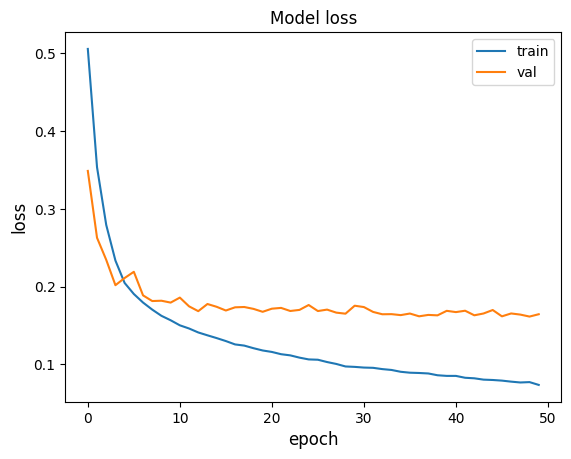

In [ ]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
5predictor.model.evaluate(x_test, y_test, return_dict=True)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9389 - f1_score: 0.5009 - fn: 972.1455 - fp: 831.9776 - loss: 0.1652 - tn: 19174.6992 - tp: 9053.1602


{'accuracy': 0.940850019454956,
 'f1_score': 0.5010866522789001,
 'fn': 1931.0,
 'fp': 1618.0,
 'loss': 0.16155590116977692,
 'tn': 38324.0,
 'tp': 18127.0}

True positive rate: 90.567354671452786917937979858411%

True negative rate: 97.316108357117820840218316559011%

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


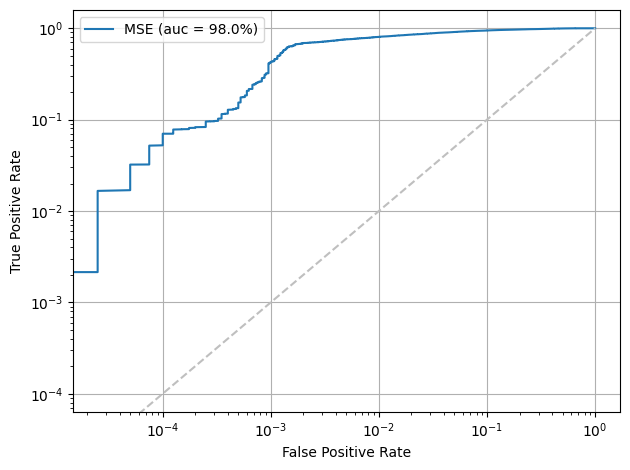

In [ ]:
def make_plot_roc_curves(model, x_test, y_test):

    true_val = y_test
    pred_val = model.predict(x_test)

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    # qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

make_plot_roc_curves(predictor, x_test, y_test)

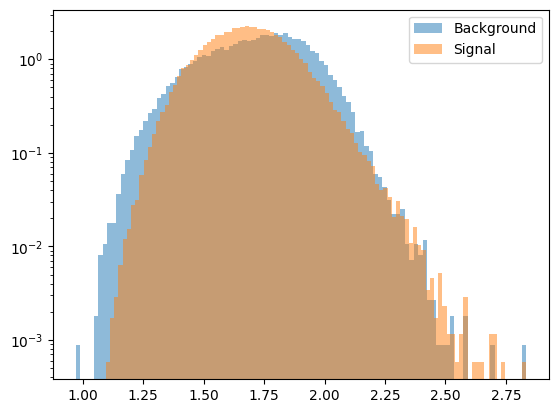

In [ ]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [ ]:
__file__='/content/drive/MyDrive/Colab Notebooks/'
model_test = Model()
model_test.load()

model_test.model.summary()
model_test.model.evaluate(x_test, y_test, return_dict=True)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 200, 2)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 200, 2)         │          1,410 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 200, 2)         │              4 │ dropout_21[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 200, 64)        │            192 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 200, 64)        │              0 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 200, 2)         │            130 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 200, 2)         │              4 │ conv1d_9[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 200, 2)         │          1,410 │ add_11[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 200, 2)         │              4 │ dropout_24[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 200, 64)        │            192 │ add_12[0][0]           │
├──────────────────────

 Total params: 444,749 (1.70 MB)

 Trainable params: 148,249 (579.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 296,500 (1.13 MB)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 149s 78ms/step - accuracy: 0.9568 - f1_score: 0.5009 - fn: 719.2601 - fp: 556.4051 - loss: 0.1422 - tn: 19450.2715 - tp: 9306.0449


{'accuracy': 0.958050012588501,
 'f1_score': 0.5010866522789001,
 'fn': 1422.0,
 'fp': 1095.0,
 'loss': 0.13774757087230682,
 'tn': 38847.0,
 'tp': 18636.0}

In [ ]:
model_test.model.evaluate(background, np.zeros((len(background), 1)), return_dict=True)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 245s 78ms/step - accuracy: 0.9901 - f1_score: 0.0000e+00 - fn: 0.0000e+00 - fp: 497.9607 - loss: 0.0348 - tn: 49534.0273 - tp: 0.0000e+00


{'accuracy': 0.990119993686676,
 'f1_score': 0.0,
 'fn': 0.0,
 'fp': 988.0,
 'loss': 0.0351204015314579,
 'tn': 99012.0,
 'tp': 0.0}

In [ ]:
model_test.model.evaluate(bbh, np.zeros((len(bbh), 1)), return_dict=True)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 244s 78ms/step - accuracy: 0.9964 - f1_score: 0.0000e+00 - fn: 0.0000e+00 - fp: 172.8999 - loss: 0.0112 - tn: 49859.0898 - tp: 0.0000e+00


{'accuracy': 0.9965199828147888,
 'f1_score': 0.0,
 'fn': 0.0,
 'fp': 348.0,
 'loss': 0.011113300919532776,
 'tn': 99652.0,
 'tp': 0.0}

In [ ]:
model_test.model.evaluate(sglf, np.ones((len(sglf), 1)), return_dict=True)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 246s 79ms/step - accuracy: 0.9776 - f1_score: 1.0000 - fn: 1116.0717 - fp: 0.0000e+00 - loss: 0.0769 - tn: 0.0000e+00 - tp: 48915.9180


{'accuracy': 0.9784500002861023,
 'f1_score': 1.0,
 'fn': 2155.0,
 'fp': 0.0,
 'loss': 0.07418987154960632,
 'tn': 0.0,
 'tp': 97845.0}

In [ ]:
transformer_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/transformer_model.keras")
transformer_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 200, 2)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 200, 2)         │          1,410 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 200, 2)         │              4 │ dropout_21[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 200, 64)        │            192 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 200, 64)        │              0 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 200, 2)         │            130 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 200, 2)         │              4 │ conv1d_9[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 200, 2)         │          1,410 │ add_11[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 200, 2)         │              4 │ dropout_24[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 200, 64)        │            192 │ add_12[0][0]           │
├──────────────────────

 Total params: 444,749 (1.70 MB)

 Trainable params: 148,249 (579.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 296,500 (1.13 MB)

In [ ]:
cov_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/cov_model.keras")
cov_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 37, 8)           │           3,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 37, 37, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 12, 12, 8)           │              16 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 1)             │           1,153 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,133 (51.30 KB)

 Trainable params: 4,377 (17.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,756 (34.21 KB)

In [ ]:
ssa_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ssa_model.keras")
ssa_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 101, 100, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 8)           │          12,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 46, 46, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 15, 15, 8)           │              16 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 1)             │           1,801 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,877 (171.40 KB)

 Trainable params: 14,625 (57.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,252 (114.27 KB)

In [ ]:
class Model:
    def __init__(self):
        super().__init__()

    def model_combinator(self, transformer_inputs, cov_inputs, ssa_inputs, dropout, l1):
      x = layers.Concatenate(axis=1)([transformer_inputs, cov_inputs, ssa_inputs])
      print(f"Concatenated shape: {x.shape}")
      x = layers.Dropout(dropout)(x)
      x = layers.LayerNormalization(epsilon=1e-6)(x)
      x = layers.Dense(8, activation="relu", kernel_regularizer=regularizers.L1(l1))(x)
      x = layers.Dropout(dropout)(x)
      x = layers.LayerNormalization(epsilon=1e-6)(x)
      x = layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.L1(l1))(x)
      return x

    def build_model(self, transformer_input_shape, cov_input_shape, ssa_input_shape, dropout=0, l1=0):
        transformer_inputs = keras.Input(shape=transformer_input_shape)
        cov_inputs = keras.Input(shape=cov_input_shape)
        ssa_inputs = keras.Input(shape=ssa_input_shape)

        self.transformer_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/transformer_model.keras")
        self.cov_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/cov_model.keras")
        self.ssa_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ssa_model.keras")

        for layer in self.transformer_model.layers:
          if isinstance(layer, layers.Dense) or isinstance(layer, layers.Conv1D) or isinstance(layer, layers.MultiHeadAttention):
            layer.kernel_regularizer = regularizers.L1(l1)
        self.transformer_model.layers[-1].activation = keras.activations.linear
        self.transformer_model.name = 'transformer_model'
        self.transformer_model.compile()

        for layer in self.cov_model.layers:
          if isinstance(layer, layers.Conv2D):
            layer.kernel_regularizer = regularizers.L1(l1)
        self.cov_model.layers[-2].activation = keras.activations.linear
        self.cov_model.name = 'covariance_model'
        self.cov_model.compile()

        for layer in self.ssa_model.layers:
          if isinstance(layer, layers.Conv2D):
            layer.kernel_regularizer = regularizers.L1(l1)
        self.ssa_model.layers[-2].activation = keras.activations.linear
        self.ssa_model.name = 'ssa_model'
        self.ssa_model.compile()

        transformer_outputs = self.transformer_model(transformer_inputs)
        cov_outputs = self.cov_model(cov_inputs)
        ssa_outputs = self.ssa_model(ssa_inputs)
        outputs = self.model_combinator(transformer_outputs, cov_outputs, ssa_outputs, dropout, l1)

        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                   keras.metrics.TruePositives(name='tp'),
                   keras.metrics.FalsePositives(name='fp'),
                   keras.metrics.TrueNegatives(name='tn'),
                   keras.metrics.FalseNegatives(name='fn')]

        self.model = keras.Model(inputs=[transformer_inputs, cov_inputs, ssa_inputs], outputs=outputs)
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                           metrics=metrics)

    def predict(self, X, batch_size=32):
        return np.where(self.model.predict(X, batch_size=batch_size) >= 0.5, 1, 0)

    def __call__(self, inputs, batch_size=64):
        return self.model.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.model.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.model = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, y_train, epochs=1, validation_split=0.0, **kwargs):
      L = 100 # The window length.
      K = x_train.shape[1] - L + 1

      if validation_split > 0:
        x_train, x_val, y_train, y_val = train_test_split(
            data, labels, test_size=validation_split, random_state=42)

      if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
      else:
        batch_size = 1

      if 'num_components' in kwargs:
        num_components = kwargs['num_components']
      else:
        num_components = 8

      for i in range(epochs):
        print(f"Epoch {i + 1}/{epochs}:")
        num_batches = int(np.ceil(x_train.shape[0]/batch_size))
        training_metrics = np.zeros(6)
        batch_index = 0
        training_loss = 0.0
        training_accuracy = 0.0
        training_tp = 0.0
        training_tn = 0.0
        training_fp = 0.0
        training_fn = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        val_tp = 0.0
        val_tn = 0.0
        val_fp = 0.0
        val_fn = 0.0

        for batch_number in range(num_batches):
          batch_x, batch_y = x_train[batch_index:min(batch_index + batch_size, x_train.shape[0])], y_train[batch_index:min(batch_index + batch_size, y_train.shape[0])]

          X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

          X = np.moveaxis(X, -1, -3)

          U, Sigma, V = np.linalg.svd(X)
          V = V.T

          svd_matrix_list = []

          cov_matrix_list = []

          for j in range(batch_x.shape[0]):
            cov_matrix_list.append(np.cov(batch_x[j]))

            batch_svd = []
            for z in range(0, num_components):
              batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])

            svd_matrix_list.append(np.array(batch_svd))

          cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

          svd_matrix = np.moveaxis(np.stack(svd_matrix_list), -3, -1)

          # print(f"Processing batch {batch_number + 1}/{num_batches}")
          training_metrics = self.model.train_on_batch(x=[batch_x, cov_matrix, svd_matrix], y=batch_y, class_weight={0:0.67, 1:1.33}, return_dict=True)
          training_loss += training_metrics['loss']/num_batches
          training_accuracy += training_metrics['accuracy']/num_batches
          training_tp += training_metrics['tp']
          training_tn += training_metrics['tn']
          training_fp += training_metrics['fp']
          training_fn += training_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Training metrics: loss = {training_loss}, accuracy = {training_accuracy}, TP = {training_tp}, TN = {training_tn}, FP = {training_fp}, FN = {training_fn}")

        num_batches = int(np.ceil(x_val.shape[0]/batch_size))
        val_metrics = np.zeros(6)
        batch_index = 0
        for batch_number in range(num_batches):
          batch_x, batch_y = x_val[batch_index:min(batch_index + batch_size, x_val.shape[0])], y_val[batch_index:min(batch_index + batch_size, y_val.shape[0])]
          X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

          X = np.moveaxis(X, -1, -3)

          U, Sigma, V = np.linalg.svd(X)
          V = V.T

          svd_matrix_list = []

          cov_matrix_list = []

          for j in range(batch_x.shape[0]):
            cov_matrix_list.append(np.cov(batch_x[j]))

            batch_svd = []
            for z in range(0, num_components):
              batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])

            svd_matrix_list.append(np.array(batch_svd))

          cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

          svd_matrix = np.moveaxis(np.stack(svd_matrix_list), -3, -1)

          val_metrics = self.model.test_on_batch(x=[batch_x, cov_matrix, svd_matrix], y=batch_y, return_dict=True)
          val_loss += val_metrics['loss']/num_batches
          val_accuracy += val_metrics['accuracy']/num_batches
          val_tp += val_metrics['tp']
          val_tn += val_metrics['tn']
          val_fp += val_metrics['fp']
          val_fn += val_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Validation metrics: loss = {val_loss}, accuracy = {val_accuracy}, TP = {val_tp}, TN = {val_tn}, FP = {val_fp}, FN = {val_fn}")

      return training_metrics, val_metrics

# Example usage:
transformer_input_shape = (200, 2)
cov_input_shape = (200, 200, 1)
ssa_input_shape = (101, 100, 16)
dropout = 0.1
l1 = 0.1

# build the model
predictor = Model()
predictor.build_model(
    transformer_input_shape=transformer_input_shape,
    cov_input_shape=cov_input_shape,
    ssa_input_shape=ssa_input_shape,
    dropout=dropout,
    l1=l1
)

# Assuming x_train is your input data
predictor.load()
history = predictor.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Concatenated shape: (None, 3)
Epoch 1/10:
Training metrics: loss = 120.92408948262529, accuracy = 0.8969583333333355, TP = 6816.0, TN = 14711.0, FP = 1291.0, FN = 1182.0
Validation metrics: loss = 6.1293788590329745, accuracy = 0.828789893617024, TP = 1924.0, TN = 3047.0, FP = 951.0, FN = 78.0
Epoch 2/10:


KeyboardInterrupt: 

In [ ]:
__file__='saved_model'
!mkdir -p saved_model
predictor.save('')

In [ ]:
final_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/final_model.keras")
final_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 200, 2)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 200, 200, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 101, 100, 16)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_model         │ (None, 1)              │        148,249 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ covariance_model          │ (None, 1)              │          4,377 │ input_layer_4[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ssa_model (Functional)    │ (None, 1)              │         14,625 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 3)              │              0 │ transformer_model[0][… │
│ (Concatenate)             │                        │                │ covariance_model[0][0… │
│                           │                        │                │ ssa_model[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 3)              │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 3)              │              6 │ dropout_6[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │             32 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 8)              │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 8)              │             16 │ dropout_7[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │              9 │ layer_normalization_3… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 501,944 (1.91 MB)

 Trainable params: 167,314 (653.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 334,630 (1.28 MB)

In [ ]:
def evaluate(model, eval_x, eval_y, batch_size=32):
  L = 100 # The window length.
  K = x_train.shape[1] - L + 1

  num_batches = int(np.ceil(eval_x.shape[0]/batch_size))
  num_components = 8
  eval_metrics = np.zeros(6)
  batch_index = 0
  eval_loss = 0.0
  eval_accuracy = 0.0
  eval_tp = 0.0
  eval_tn = 0.0
  eval_fp = 0.0
  eval_fn = 0.0

  for batch_number in range(num_batches):
    batch_x, batch_y = eval_x[batch_index:min(batch_index + batch_size, eval_x.shape[0])], eval_y[batch_index:min(batch_index + batch_size, eval_y.shape[0])]
    X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

    X = np.moveaxis(X, -1, -3)

    U, Sigma, V = np.linalg.svd(X)
    V = V.T

    svd_matrix_list = []

    cov_matrix_list = []

    for j in range(batch_x.shape[0]):
      cov_matrix_list.append(np.cov(batch_x[j]))

      batch_svd = []
      for z in range(0, num_components):
        batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])

      svd_matrix_list.append(np.array(batch_svd))

    cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

    svd_matrix = np.moveaxis(np.stack(svd_matrix_list), -3, -1)

    eval_metrics = model.test_on_batch(x=[batch_x, cov_matrix, svd_matrix], y=batch_y, return_dict=True)
    eval_loss += eval_metrics['loss']/num_batches
    eval_accuracy += eval_metrics['accuracy']/num_batches
    eval_tp += eval_metrics['tp']
    eval_tn += eval_metrics['tn']
    eval_fp += eval_metrics['fp']
    eval_fn += eval_metrics['fn']
    batch_index += batch_size

    model.reset_metrics()

  print(f"Evaluation metrics: loss = {eval_loss}, accuracy = {eval_accuracy}, TP = {eval_tp}, TN = {eval_tn}, FP = {eval_fp}, FN = {eval_fn}")

In [ ]:
evaluate(final_model, x_test, y_test)

Evaluation metrics: loss = 841.7839490559907, accuracy = 0.9789500000000327, TP = 19334.0, TN = 39403.0, FP = 539.0, FN = 724.0


True positive rate: 96.4%

True negative rate: 98.7%

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Model():
    def __init__(self):
        super().__init__()
        self.L = 100
        self.K = 0
        self.num_components = 8

    def load(self):
        self.model = keras.models.load_model('model.keras')

    def predict(self, X, batch_size=32):
        self.K = X.shape[1] - self.L + 1
        output_array = np.empty(X.shape[0])
        num_batches = int(np.ceil(X.shape[0]/batch_size))
        batch_index = 0
        for batch_number in range(num_batches):
            batch_X = X[batch_index:min(batch_index + batch_size, X.shape[0])]
            A = np.stack([batch_X[:, i:i + self.L] for i in range(0, self.K)], axis=1)

            A = np.moveaxis(A, -1, -3)

            U, Sigma, V = np.linalg.svd(A)
            V = V.T

            svd_matrix_list = []

            cov_matrix_list = []

            for j in range(batch_X.shape[0]):
                cov_matrix_list.append(np.cov(batch_X[j]))

                batch_svd = []
                for z in range(0, self.num_components):
                    batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])

                svd_matrix_list.append(np.array(batch_svd))

            cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

            svd_matrix = np.moveaxis(np.stack(svd_matrix_list), -3, -1)

            output_array[batch_index:min(batch_index + batch_size, X.shape[0])] = self.model.predict_on_batch([batch_X, cov_matrix, svd_matrix]).flatten()

            batch_index += batch_size

In [ ]:
test_model = Model()
test_model.load()
test_model.predict(x_test)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


(1000,)
(1000,)
[0.61783636 0.06520917 0.06514546 0.96586955 0.06623014 0.07012574
 0.96462172 0.06493014 0.06541059 0.96583974 0.06596761 0.0658012
 0.06497309 0.96575594 0.06529481 0.96490353 0.96494418 0.96579063
 0.96387255 0.96487057 0.0648551  0.96583498 0.06702248 0.06526612
 0.06544814 0.88853091 0.06486773 0.96530992 0.06512125 0.96529281
 0.06580982 0.96581674 0.06533225 0.96300817 0.96329856 0.96536517
 0.08400885 0.06729643 0.07868019 0.06588446 0.06690144 0.06542415
 0.07790749 0.06514713 0.07960579 0.06538887 0.06586667 0.06494811
 0.06490632 0.96550727 0.06485034 0.06892884 0.96529341 0.06685377
 0.06583526 0.96441823 0.06611542 0.06559069 0.06535684 0.965859
 0.9652313  0.06548595 0.06642743 0.06574033 0.06541605 0.06521782
 0.0657862  0.9653796  0.06828872 0.06607813 0.06510006 0.06534126
 0.06485304 0.06511784 0.06730389 0.96473712 0.13175115 0.06542833
 0.95993763 0.0660178  0.07911245 0.06675601 0.96067923 0.06558736
 0.9642086  0.06628148 0.0661201  0.12257443 0.06